In [ ]:
!pip install mne scipy
!pip install pyqt5

import scipy.io
import numpy as np
import matplotlib
import mne
import os
import pathlib
import pandas as pd
import shutil
from pathlib import Path

matplotlib.use('Agg')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 15.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
eeg_data = np.load('/content/drive/My Drive/mindlock-eeg-files/session-1/eeg-data.npy')
eeg_labels = np.load('/content/drive/My Drive/mindlock-eeg-files/session-1/eeg-labels.npy')


In [ ]:
eeg_data.shape

(17033, 65, 251, 1)

In [ ]:
from sklearn.utils import shuffle
eeg_data, eeg_labels = shuffle(eeg_data, eeg_labels, random_state=42)

random_index = np.random.randint(0, len(eeg_data))


Randomly selected EEG file (index: 14001) has label: 75


In [ ]:
np.unique(eeg_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(eeg_data, eeg_labels, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is (n_channels, n_timepoints, 1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

cnn_model = Sequential()

cnn_model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


cnn_model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


cnn_model.add(Flatten())
cnn_model.add(Dense(90, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
cnn_model.compile(optimizer=optm,
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 251, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 251, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 125, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 125, 16)         │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 125, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 62, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 31, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 90)                  │         714,330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 720,442 (2.75 MB)

 Trainable params: 720,330 (2.75 MB)

 Non-trainable params: 112 (448.00 B)

In [ ]:
history = cnn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Epoch 1/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 136s 475ms/step - accuracy: 0.7404 - loss: 2.5942 - val_accuracy: 0.4412 - val_loss: 3.4445
Epoch 2/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 140s 465ms/step - accuracy: 0.8890 - loss: 1.8304 - val_accuracy: 0.4334 - val_loss: 3.2283
Epoch 3/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 139s 457ms/step - accuracy: 0.9448 - loss: 1.4219 - val_accuracy: 0.6011 - val_loss: 2.3455
Epoch 4/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 142s 458ms/step - accuracy: 0.9761 - loss: 1.1119 - val_accuracy: 0.7055 - val_loss: 1.8441
Epoch 5/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 133s 463ms/step - accuracy: 0.9840 - loss: 0.8888 - val_accuracy: 0.6745 - val_loss: 1.8386
Epoch 6/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 140s 458ms/step - accuracy: 0.9869 - loss: 0.7367 - val_accuracy: 0.7379 - val_loss: 1.4665
Epoch 7/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 141s 457ms/step - accuracy: 0.9941 - loss: 0.5920 - val_accuracy: 0.7051 - val_loss: 1.4698
Epoch 8/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 143s 459ms/step - accuracy: 0.9932 -

In [ ]:
cnn_model.save('/content/drive/MyDrive/mindlock-eeg-files/model/predict-subject-model.keras')
import pickle
from joblib import load

svm_model_path = '/content/drive/MyDrive/mindlock-eeg-files/model/for-train-svm_model.pkl'
svm_model = load(svm_model_path)

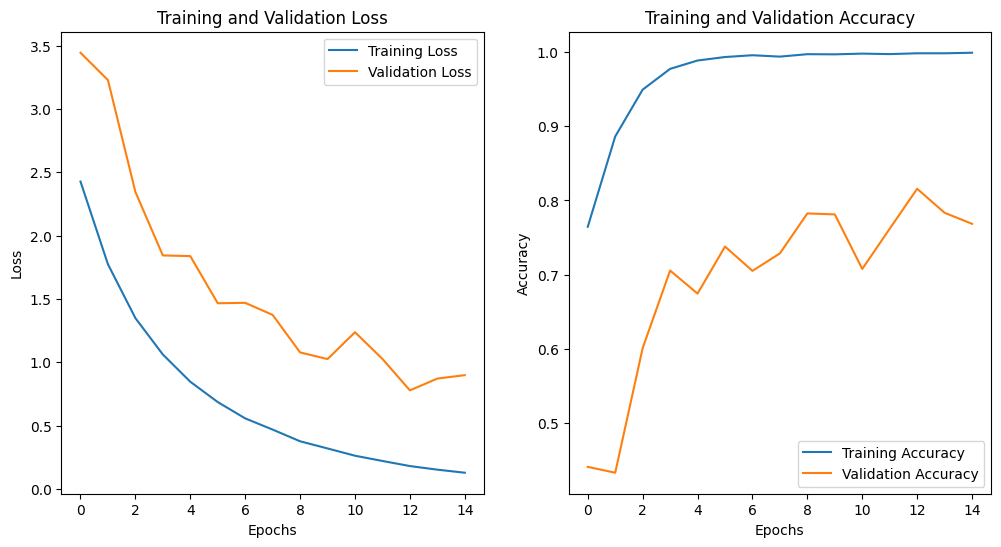

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

X_train_features = cnn_model.predict(X_train)
X_test_features = cnn_model.predict(X_test)

X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

from sklearn.svm import SVC
svm_model = SVC(kernel='rbf') #linear 1 rbf 2
svm_model.fit(X_train_features, y_train)

y_pred = svm_model.predict(X_test_features)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')


print(f'Accuracy on labeled test set: {accuracy * 100:.2f}%')
print(f'Precision on labeled test set: {precision * 100:.2f}%')
print(f'Recall on labeled test set: {recall * 100:.2f}%')

358/358 ━━━━━━━━━━━━━━━━━━━━ 57s 160ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step
Accuracy on labeled test set: 81.27%
Precision on labeled test set: 82.96%
Recall on labeled test set: 81.29%


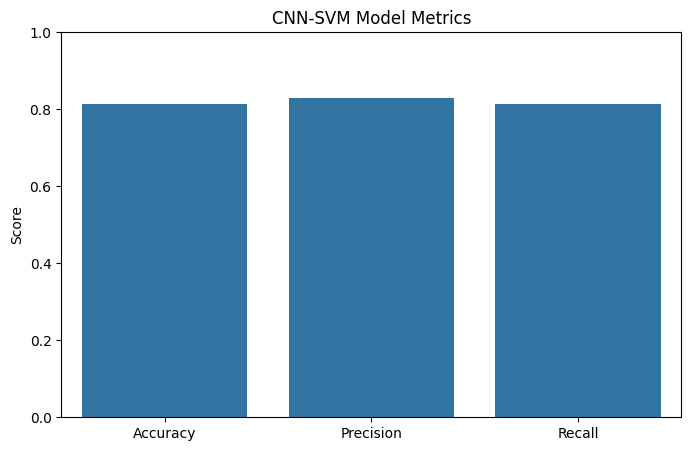

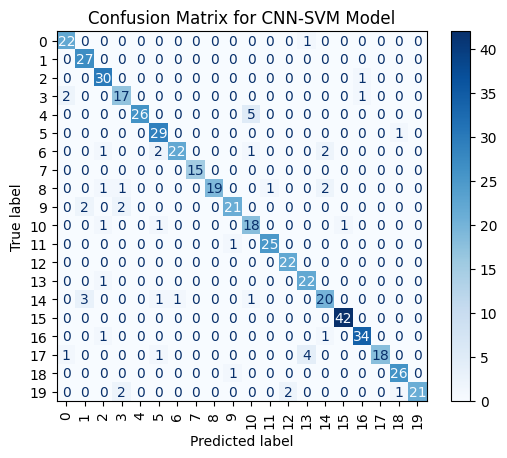

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Visualization

plt.figure(figsize=(8, 5))
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]
sns.barplot(x=metrics, y=values)
plt.title('CNN-SVM Model Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

num_classes_to_display = 20

filtered_y_test = np.array([y for y in y_test if y < num_classes_to_display])
filtered_y_pred = np.array([y_pred[i] for i in range(len(y_pred)) if y_test[i] < num_classes_to_display])


cm_filtered = confusion_matrix(filtered_y_test, filtered_y_pred, labels=range(num_classes_to_display))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_filtered, display_labels=range(num_classes_to_display))
disp.plot(cmap='Blues')

plt.title('Confusion Matrix for CNN-SVM Model')
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
csv_path = '/content/drive/MyDrive/mindlock-eeg-files/session-1/classification-report-initial.csv'

report_df.to_csv(csv_path, index=True)

Classification report saved to /content/drive/MyDrive/mindlock-eeg-files/session-1/classification-report-initial.csv
